<a href="https://colab.research.google.com/github/DARoSLab/CS403-Intro-Robotics/blob/main/Lecture/Lecture17_feedback-control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 17. Feedback Control

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import math 
import time 
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

# System: Swing Stick
<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw6/SwingArm.png?raw=true" width="500">

# $u = K_p (\theta_{\rm des} - \theta)$.

[$m, I, c, l, \mu, dt$] = [1, 0.05, 0.5, 1.0, 0, 0.001]. 

In [29]:
theta_des = 0.5
theta_dot_des = 0
F_disturbance = 0
Kp = 50
Kd = np.sqrt(Kp*(1*0.5*0.5 + 0.05))*2
print(Kd)

7.745966692414834


In [12]:
def sim_step(theta, theta_dot, F, tau , params=None):
  m, I, c, l, mu, dt = params
  # Fill your code: implement dynamics to compute the angular acceleration
  theta_ddot = (F*l*np.cos(theta) + tau - mu*theta_dot)/(m*c*c + I)

  # Fill your code: Semi-implciti Euler integration
  th_dot = theta_dot + theta_ddot*dt;
  th = theta + th_dot*dt;

  return [th, th_dot]
  
def simulate_stick(theta=0, theta_dot=0, F=50, F_duration=0.05, F_start_time=0.0, T=1.0, params=None):
  dt = params[-1]
  ts = np.linspace(0, T, int(T/dt))
  theta_hist = [theta]
  theta_dot_hist = [theta_dot]

  # Fill your code: Implement the case that the external force pushes the tip of the arm
  for i, t in enumerate(ts):
    tau = Kp* (theta_des - theta) + Kd*(theta_dot_des - theta_dot)

    if t>=F_start_time and t<= F_start_time + F_duration:
     [theta, theta_dot] = sim_step(theta, theta_dot, F, tau, params=params)
    else:
     [theta, theta_dot] = sim_step(theta, theta_dot, 0, tau, params=params) 

    theta_hist.append(theta)
    theta_dot_hist.append(theta_dot)

  ts = ts.tolist()
  ts.append(T)
  return [theta_hist, theta_dot_hist, ts]

In [13]:
# Visualization code: Do not need to change
def plot_stick(q, ts, params, num_frames= 100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  m, I, c, l, mu, dt = params
  link1, = ax.plot([], [], 'b', lw=10)     # ax.plot returns a list of 2D line objects  
  plt.plot([0, 2*np.cos(theta_des)], [0, 2*np.sin(theta_des)], 'r--', lw = 2)
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -1.0, 2.5))    # Canvas size        
  ax.set_ylim((-1.0, 2.5))
  txt_title = ax.set_title('')
  interval = len(q)//num_frames

  def drawFrame(k):
    k = interval*k
    q0 = q[k]
    rA = [l*np.cos(q0), l*np.sin(q0)]
    x1 = 0
    x2 = rA[0]
    y1 = 0
    y2 = rA[1]
    link1.set_data([x1, x2], [y1, y2])
    txt_title.set_text('t = {:.2f} sec'.format(ts[k]))
    return link1, 

  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

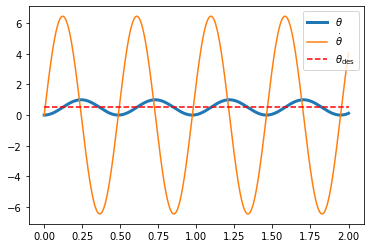

In [14]:
# Let's use param: [mass, Inertia, CoM, length, friction coefficient, delta_t]
# Fill your code: Run simulation
params=[1, 0.05, 0.5, 1.0, 0.0, 0.001]
[theta_hist, theta_dot_hist, ts] = simulate_stick(theta=0, theta_dot=0, F=F_disturbance, F_duration=0.1, F_start_time=0.8, T=2.0, params=params)


# Joint position and velocity plots (No need to change)
plt.plot(ts, theta_hist, label=r'$\theta$', lw = 3)
plt.plot(ts, theta_dot_hist, label=r'$\dot{\theta}$')
plt.plot([0, ts[-1]], [theta_des, theta_des],'r--', label=r'$\theta_{\rm des}$')
plt.legend()
plt.show()

In [15]:
anim = plot_stick(theta_hist, ts, params)
plt.close()
HTML(anim.to_html5_video())

# **Tracking Control**

In [34]:
amp = 0.5
omega = 2*np.pi*0.6
F_disturbance = 0
Kp = 50
Kd = np.sqrt(Kp*(1*0.5*0.5 + 0.05))*2

In [35]:
def simulate_stick_tracking(theta=0, theta_dot=0, F=50, F_duration=0.05, F_start_time=0.0, T=1.0, params=None):
  dt = params[-1]
  ts = np.linspace(0, T, int(T/dt))
  theta_hist = [theta]
  theta_dot_hist = [theta_dot]
  th_des_hist = [0]
  th_dot_des_hist = [0]

  # Fill your code: Implement the case that the external force pushes the tip of the arm
  for i, t in enumerate(ts):
    theta_des = amp*np.sin(omega*t)
    theta_dot_des = amp*omega*np.cos(omega*t)

    tau = Kp* (theta_des - theta) + Kd*(theta_dot_des - theta_dot)
    [theta, theta_dot] = sim_step(theta, theta_dot, 0, tau, params=params) 

    theta_hist.append(theta)
    theta_dot_hist.append(theta_dot)
    th_des_hist.append(theta_des)
    th_dot_des_hist.append(theta_dot_des)

  ts = ts.tolist()
  ts.append(T)
  return [theta_hist, theta_dot_hist, th_des_hist, th_dot_des_hist, ts]

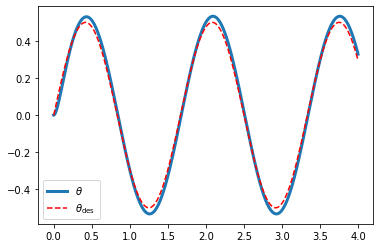

In [44]:
# Let's use param: [mass, Inertia, CoM, length, friction coefficient, delta_t]
# Fill your code: Run simulation
params=[1, 0.05, 0.5, 1.0, 0.0, 0.001]
[theta_hist_track, theta_dot_hist, th_des_hist_track, th_dot_des_hist, ts_track] = \
   simulate_stick_tracking(theta=0, theta_dot=0, F=F_disturbance, F_duration=0.1, F_start_time=0.8, T=4.0, params=params)


# Joint position and velocity plots (No need to change)
plt.plot(ts_track, theta_hist_track, label=r'$\theta$', lw = 3)
plt.plot(ts_track, th_des_hist_track,'r--', label=r'$\theta_{\rm des}$')
plt.legend()
plt.show()

In [50]:
# Visualization code: Do not need to change
def plot_stick_tracking(q, qdes, ts, params, num_frames= 100):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)   
  m, I, c, l, mu, dt = params
  link1, = ax.plot([], [], 'b', lw=10)     # ax.plot returns a list of 2D line objects  
  txt_title = ax.set_title('')
  
  ax.set_xlim(( -1.0, 2.5))    # Canvas size        
  ax.set_ylim((-1.0, 2.5))
  txt_title = ax.set_title('')
  interval = len(q)//num_frames

  def drawFrame(k):
    k = interval*k
    # print(qdes[k])

    q0 = q[k]
    rA = [l*np.cos(q0), l*np.sin(q0)]
    x1 = 0
    x2 = rA[0]
    y1 = 0
    y2 = rA[1]
    link1.set_data([x1, x2], [y1, y2])
    txt_title.set_text('t = {:.2f} sec'.format(ts[k]))
    return link1, 

  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

In [49]:
anim = plot_stick_tracking(theta_hist_track, th_des_hist_track, ts_track, params)
plt.close()
HTML(anim.to_html5_video())

0
0
0
0.0732668851111453
0.14675545988826674
0.21691153494226192
0.2821420172401966
0.34096566332875905
0.39204671517582784
0.43422523235215466
0.4665434317747862
0.48826743689350866
0.49890394244323377
0.498211416341772
0.4862055843620734
0.4631590730338678
0.4295952188836378
0.38627618459172125
0.33418565192296595
0.2745064844371214
0.2085938672106025
0.13794453350856453
0.06416277720314205
-0.011075977277525465
-0.08606322022166292
-0.15909615320160297
-0.22851635595059613
-0.2927474455073787
-0.3503308724706058
-0.39995904150748574
-0.44050500402134896
-0.4710480487217658
-0.490894608990601
-0.499594012282852
-0.4969487139273707
-0.4830187829399467
-0.4581205379856171


CalledProcessError: ignored